In [1]:
from __future__ import print_function, division

In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess


from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [38]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds)

Dropped levels [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28]


# Climlab

#### All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

-0.34498416 #m^2/s

## To do:
1. Make functions within the turbulence class
2. Make class for ram_ensemble of ram_dict
```python
class ram_ensemble():
    def __init__(self, ds):
        ram_dict = {}
        fill_ensemble(ds, ram_dict)
        
    def timestep_ensemble():
        for ram in ram_dict:
```
3. Get rid of experiments and change it to ds
4. Set surface diff k in this notebook
            

In [112]:
def fill_ensemble(ds, ram_dict, surface_diffk):
    for CO2 in ds['CO2_list'].values:
        ram_dict[CO2] = {}
        for m in np.asarray(ds['month']):
            ram = ram_model.init_ram(ds, m, .00038, surface_diffk)
            ram_dict[CO2][m] = {}
            ram_dict[CO2][m] = ram
    return ram_dict

In [115]:
ram_dict = {}
ram_dict = fill_ensemble(ds, ram_dict, surface_diffk = -2)

In [122]:
ram_dict[.0001]['December'].z

<xarray.DataArray 'Altitude' (level: 70)>
array([57173.  , 52173.  , 47173.  , 42173.  , 38131.  , 37173.  ,
       32173.  , 27173.  , 26785.21, 23380.04, 21079.38, 19339.57,
       17940.07, 16769.29, 15762.85, 14880.26, 14094.34, 13386.  ,
       12741.28, 12149.69, 11603.14, 11095.25, 10620.91, 10175.96,
        9756.98,  9361.09,  8985.89,  8629.32,  8289.61,  7965.25,
        7654.9 ,  7357.41,  7071.75,  6797.02,  6532.41,  6277.2 ,
        6030.75,  5792.48,  5561.85,  5338.4 ,  5121.7 ,  4911.34,
        4706.96,  4508.24,  4314.87,  4126.57,  3943.08,  3764.16,
        3589.59,  3419.16,  3252.68,  3089.97,  2930.87,  2775.21,
        2622.86,  2473.67,  2327.52,  2184.28,  2043.84,  1906.09,
        1770.94,  1638.28,  1508.03,  1418.55,  1305.88,  1201.42,
        1104.58,  1014.79,   496.12,     0.  ])
Coordinates:
    month    <U8 'December'
  * level    (level) int64 69 68 67 66 65 64 63 62 61 60 ... 9 8 7 6 5 4 3 2 1 0

In [81]:
def annual_mean_sfc_diffk(ram_dict):
    sum_surface_diffk = 0
    for m in np.asarray(ds['month']):
            sum_surface_diffk += ram_dict[0.00038][m].surface_diffk
    average_surface_diffk = sum_surface_diffk/12
    return average_surface_diffk

In [127]:
class ram_ensemble():
    def __init__(self, ds):
        #ram dict to find average surface diffk
        ram_dict_avg_diffk = {}
        ram_dict_avg_diffk = fill_ensemble(ds, ram_dict_avg_diffk, surface_diffk = None)
        average_surface_diffk = annual_mean_sfc_diffk(ram_dict_avg_diffk)
        
    def first_timestep(self):
        #ram dict for initial state with average surface diffk
        ram_dict = {}
        ram_dict = fill_ensemble(ds, ram_dict, surface_diffk = average_surface_diffk)
        


In [129]:
## FIX THE FIIRST TIMESTEP

# Output (initial and over time)

### Initial

In [8]:
###set up lists and variables
diagnostics_list = list(ram_dict[experiment.name][CO2][m].diagnostics.keys())
temp_list = ['Ts','Tatm']
adv_dict = {'advection_Ts':'Ts','advection_Tatm':'Tatm'}
output_list = temp_list + diagnostics_list + list(adv_dict.keys()) + ['lev_bounds'] + ['time']
print('Outputs available ' + str(output_list))
print('CO2 values ' + str(experiment['CO2_list'].values))
print('timestep ' + str(timestep) + ' seconds')

Outputs available ['Ts', 'Tatm', 'OLR', 'OLRclr', 'OLRcld', 'TdotLW', 'TdotLW_clr', 'LW_sfc', 'LW_sfc_clr', 'LW_flux_up', 'LW_flux_down', 'LW_flux_net', 'LW_flux_up_clr', 'LW_flux_down_clr', 'LW_flux_net_clr', 'ASR', 'ASRclr', 'ASRcld', 'TdotSW', 'TdotSW_clr', 'SW_sfc', 'SW_sfc_clr', 'SW_flux_up', 'SW_flux_down', 'SW_flux_net', 'SW_flux_up_clr', 'SW_flux_down_clr', 'SW_flux_net_clr', 'total_sfc_flux_init', 'theta_init', 'dtheta_dz_surf_init', 'surface_diffk', 'theta', 'dtheta_dz', 'atm_diffk', 'atm_turbulent_flux', 'sfc_turbulent_flux', 'atm_hr', 'sfc_hr', 'hr', 'z', 'z_bounds', 'advection_Ts', 'advection_Tatm', 'lev_bounds', 'time']
CO2 values [0.0001  0.0002  0.00038 0.00076 0.001   0.0015 ]
timestep 600 seconds


In [9]:
### create dictionary for results
results_dict = {}

In [10]:
### results at first timestep
results_dict[0] = {}
for output in output_list:
    results_dict[0][output] = {}
    for CO2 in ds['CO2_list'].values:
        results_dict[0][output][CO2] = {}
        for m in months:
            results_dict[0][output][CO2][m] = {}
            if output in (diagnostics_list):
                results_dict[0][output][CO2][m] = (ram_dict[experiment.name][CO2][m].diagnostics[output])
            if output in temp_list:
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].state[output])
            if output in list(adv_dict.keys()):
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
            if output == 'lev_bounds':
                results_dict[0][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].lev_bounds)
            if output == 'time':
                results_dict[0]['time'][CO2][m] = list(ram_dict[experiment.name][CO2][m].time)


### Timestep forward

In [11]:
steps = 10
### results for each timestep
for i in range(steps):
    #step model forward
    results_dict[(i+1)*timestep] = {}
    for count, output in enumerate(output_list):
        results_dict[(i+1)*timestep][output] = {}
        for CO2 in ds['CO2_list'].values:
            results_dict[(i+1)*timestep][output][CO2] = {}
            for m in months:
                results_dict[(i+1)*timestep][output][CO2][m] = {}
                if count==0:
                    ram_dict[experiment.name][CO2][m].step_forward()
                #add outputs/diagnostics
                if output in (diagnostics_list):
                    results_dict[(i+1)*timestep][output][CO2][m] = (ram_dict[experiment.name][CO2][m].diagnostics[output])
                if output in temp_list:
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].state[output])
                if output in list(adv_dict.keys()):
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].subprocess.Advection.forcing_tendencies[adv_dict[output]])
                if output == 'lev_bounds':
                    results_dict[(i+1)*timestep][output][CO2][m] = list(ram_dict[experiment.name][CO2][m].lev_bounds)

In [12]:
ram_dict[experiment.name][.00076]['June'].time

{'timestep': 600,
 'num_steps_per_year': 52594.876800000005,
 'day_of_year_index': 10,
 'steps': 10,
 'days_elapsed': 0.06944444444444446,
 'years_elapsed': 0,
 'days_of_year': array([0.00000000e+00, 6.94444444e-03, 1.38888889e-02, ...,
        3.65222222e+02, 3.65229167e+02, 3.65236111e+02]),
 'active_now': True}

#### plotting functions

In [13]:
def plot_time_dif(outputs, CO2_conc1, time1, time2, month, figsize, rows, columns, diff_only=False):
    fig = plt.figure(figsize = figsize)
    for idx, output in enumerate(outputs):
        ax = fig.add_subplot(rows, columns, idx +1)
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr'):
            x1 = np.asarray(results_dict[time1][output][CO2_conc1][month])/86400
        else: 
            x1 = np.asarray(results_dict[time1][output][CO2_conc1][month])
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr' or output == 'Tatm' or output == 'atm_hr' or output == 'advection_Tatm'):
            y1 = np.asarray(results_dict[time1][output_dict['bounds'][output]][CO2_conc1][month][:-1])
        else:
            y1 = np.asarray(results_dict[time1][output_dict['bounds'][output]][CO2_conc1][month])
                        
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr'):
            x2 = np.asarray(results_dict[time2][output][CO2_conc1][month])/86400
        else: 
            x2 = results_dict[time2][output][CO2_conc1][month]
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr' or output == 'Tatm' or output == 'atm_hr' or output == 'advection_Tatm'):
            y2 = results_dict[time2][output_dict['bounds'][output]][CO2_conc1][month][:-1]
        else:
            y2 = results_dict[time2][output_dict['bounds'][output]][CO2_conc1][month]

        if diff_only:
            plt.plot(x2-x1, y1, color = 'C0', label = f'{output} at {time1}');
        else:
            plt.plot(x1, y1, color = 'C0', label = f'{output} at {time1}');
            plt.plot(x2, y2, color = 'C1',label = f'{output} at {time2}');
            
            
        plt.legend()
        plt.ylabel('Altitude')
        #plt.ylim([0,10000])
        plt.xlabel(f'{output}')
        plt.title(f'{output} in {month} at CO2 {CO2_conc1}')
    
def plot_co2_dif(outputs, CO2_conc1, CO2_conc2, time1, month, figsize, rows, columns):
    fig = plt.figure(figsize = figsize)
    for idx, output in enumerate(outputs):  
        ax = fig.add_subplot(rows, columns, idx +1)
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr'):
            x1 = np.asarray(results_dict[time1][output][CO2_conc1][month])/86400
        else: 
            x1 = np.asarray(results_dict[time1][output][CO2_conc1][month])
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr' or output == 'Tatm' or output == 'atm_hr' or output == 'advection_Tatm'):
            y1 = np.asarray(results_dict[time1][output_dict['bounds'][output]][CO2_conc1][month][:-1])
        else:
            y1 = np.asarray(results_dict[time1][output_dict['bounds'][output]][CO2_conc1][month])
                        
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr'):
            x2 = np.asarray(results_dict[time1][output][CO2_conc2][month])/86400
        else: 
            x2 = results_dict[time1][output][CO2_conc2][month]
        if (output == 'TdotLW_clr' or output == 'TdotSW_clr' or output == 'Tatm' or output == 'atm_hr' or output == 'advection_Tatm'):
            y2 = results_dict[time1][output_dict['bounds'][output]][CO2_conc2][month][:-1]
        else:
            y2 = results_dict[time1][output_dict['bounds'][output]][CO2_conc2][month]

        plt.plot(x1, y1, color = 'C0', label = f'{output} at {CO2_conc1}');
        plt.plot(x2, y2, color = 'C1',label = f'{output} at {CO2_conc2}');

        plt.legend()
        plt.ylabel('Altitude')
        plt.xlabel(f'{output}')
        plt.title(f'{output} in {month} at CO2 {CO2_conc1} and {CO2_conc2} at t= {time1}')
        
def single_level_plot(output, CO2_conc1, CO2_conc2, month):
    fig, ax = plt.subplots(figsize = [6,4])
    for t in list(results_dict.keys())[0::10]:
        plt.plot(t,results_dict[t][output][CO2_conc1][month],'ro')
        plt.plot(t,results_dict[t][output][CO2_conc2][month],'b.')
        plt.xlabel('Time (seconds)')
        plt.ylabel(f'{output}')
        plt.legend([f'{CO2_conc1}',f'{CO2_conc2}'])

#### parameters for plots

In [14]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = (1008)*timestep
month = 'December'

###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','atm_hr':'z', 
               'hr':'z', 'advection_Tatm':'z'}


#### CO2 difference plots

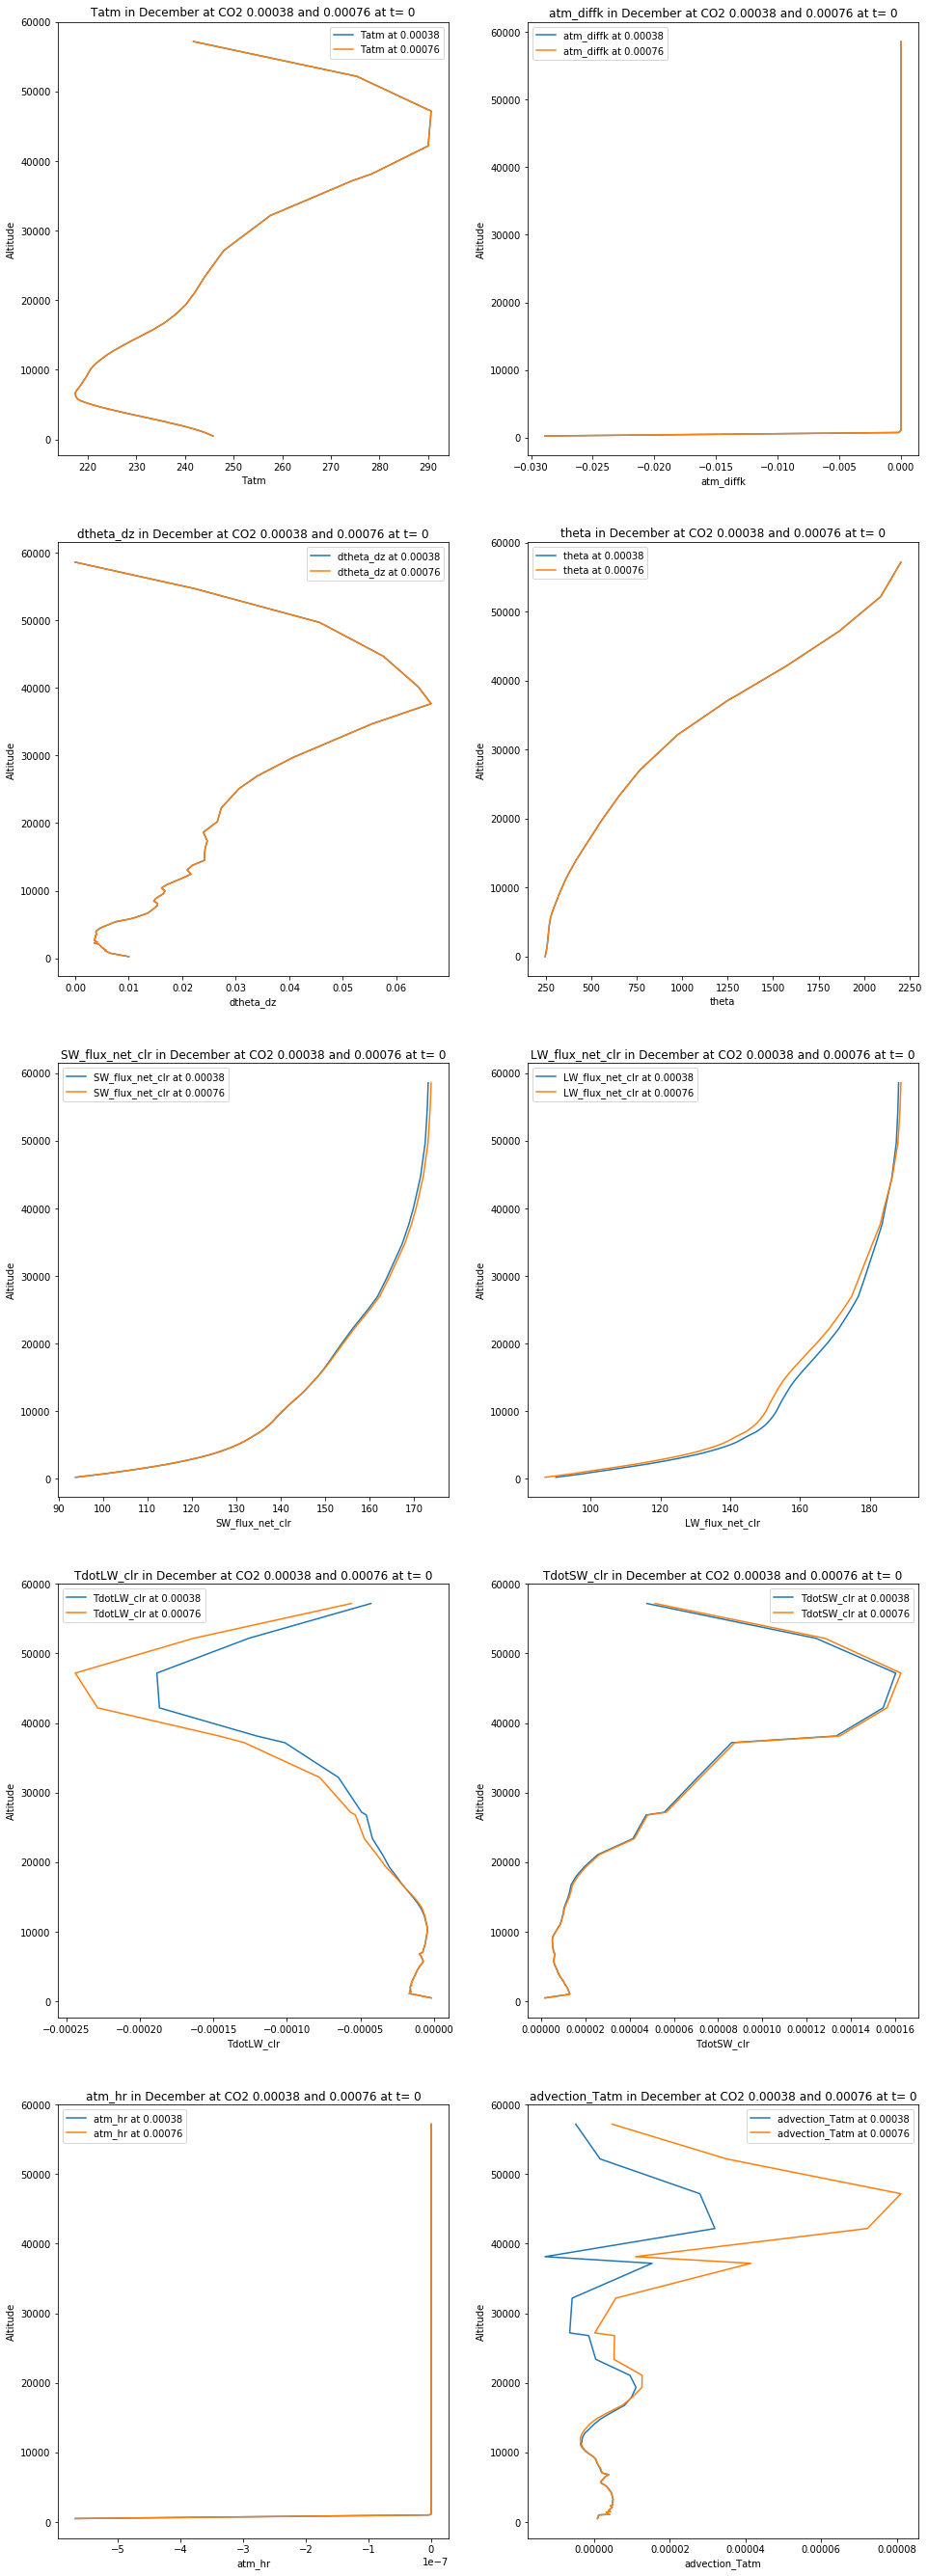

In [238]:
plot_co2_dif(outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
             CO2_conc1 = CO2_conc1,CO2_conc2 = CO2_conc2, time1 = time1, month = month,figsize = [16,48], rows =5, columns =2)

#### time difference plots

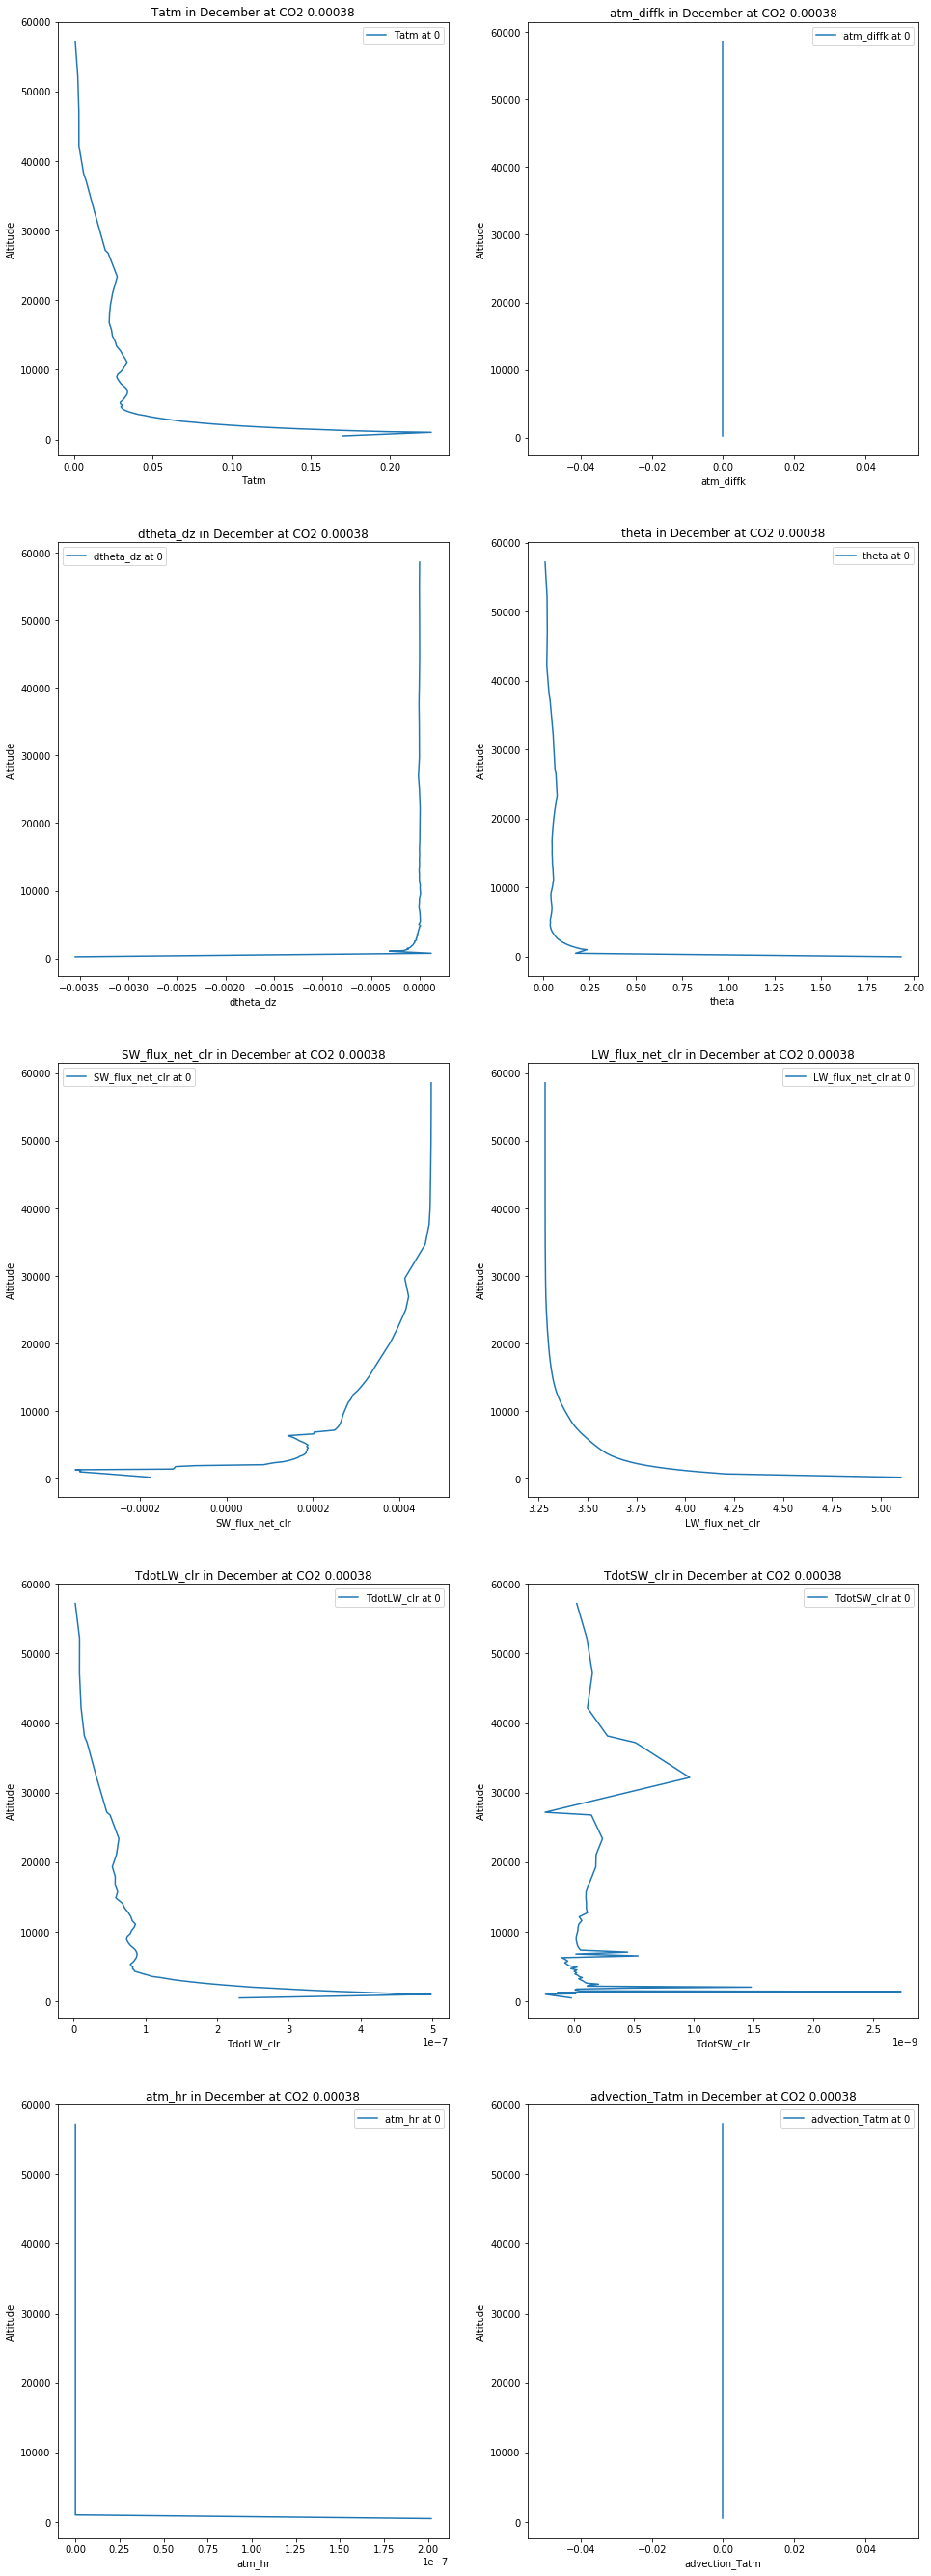

In [242]:
plot_time_dif(
    outputs = ['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','atm_hr','advection_Tatm'],
    CO2_conc1 = CO2_conc1, time1 = time1, time2 = time2, month = month, figsize = [16,48], rows =5, columns =2, diff_only =True
)


#### single level process plots: 

LW_sfc_clr, Ts, ASRclr, SW_sfc_clr, total_sfc_flux_init, dtheta_dz_surf_init, surface_diffk, sfc_turbulent_flux, sfc_hr, advection_Ts, OLR

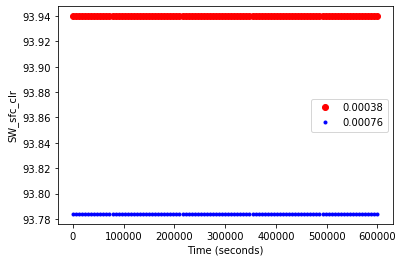

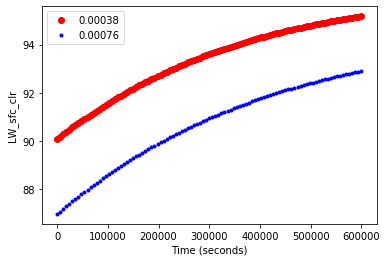

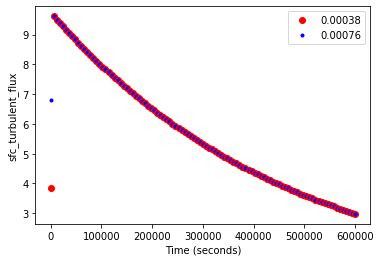

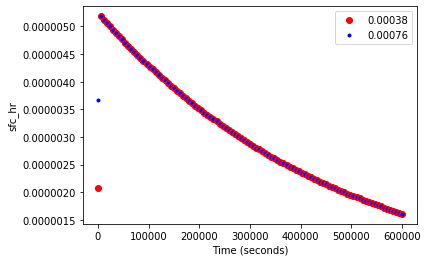

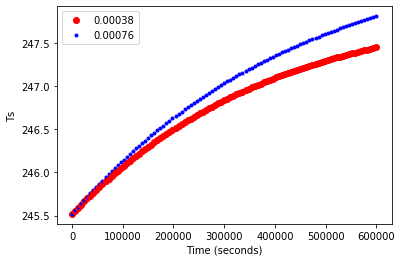

In [243]:
single_level_plot('SW_sfc_clr', CO2_conc1, CO2_conc2, month)
single_level_plot('LW_sfc_clr', CO2_conc1, CO2_conc2, month)
single_level_plot('sfc_turbulent_flux', CO2_conc1, CO2_conc2, month)
single_level_plot('sfc_hr', CO2_conc1, CO2_conc2, month)
single_level_plot('Ts', CO2_conc1, CO2_conc2, month)

#### sum of heating rates

Text(0.5, 1.0, 'Sum of heating rates in December at CO2 0.00038')

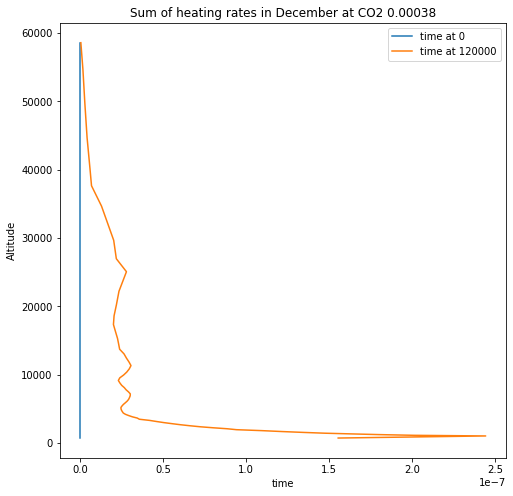

In [212]:
### plot the sum of our heating rates

fig = plt.figure(figsize = [8,8])

ax = fig.add_subplot(1, 1, 1)
x1 = np.asarray(results_dict[time1]['TdotLW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time1]['TdotSW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time1]['atm_hr'][CO2_conc1][month]) + np.asarray((results_dict[time1]['advection_Tatm'][CO2_conc1][month]))

y1 = results_dict[time1]['z_bounds'][CO2_conc1][month][:-1]

x2 = np.asarray(results_dict[time2]['TdotLW_clr'][CO2_conc1][month]/86400) + np.asarray(results_dict[time2]['TdotSW_clr'][CO2_conc1][month]/86400)+ np.asarray(results_dict[time2]['atm_hr'][CO2_conc1][month]) + np.asarray(results_dict[time2]['advection_Tatm'][CO2_conc1][month])

y2 = results_dict[time2]['z_bounds'][CO2_conc1][month][:-1]

plt.plot(x1, y1, color = 'C0', label = f'{output} at {time1}');
plt.plot(x2, y2, color = 'C1', label = f'{output} at {time2}');

plt.legend()
plt.ylabel('Altitude')
plt.xlabel(f'{output}')
plt.title(f'Sum of heating rates in {month} at CO2 {CO2_conc1}')

In [16]:
print('initial lowest Tatm heating rate is: ')
print((np.asarray(list(results_dict[time1]['TdotLW_clr'][CO2_conc1][month]/86400)) + np.asarray(list(results_dict[time1]['TdotSW_clr'][CO2_conc1][month]/86400)) + np.asarray(list(results_dict[time1]['atm_hr'][CO2_conc1][month])) + np.asarray(list(results_dict[time1]['advection_Tatm'][CO2_conc1][month])))[-1])
print('K/sec')

initial lowest Tatm heating rate is: 
-2.117582368135751e-22
K/sec


#### solar insolation

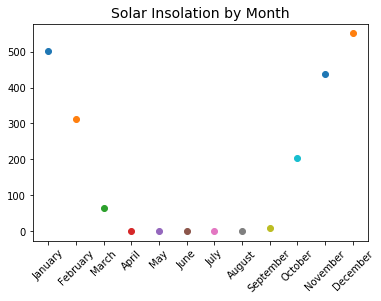

In [15]:
###plot solar insolation by month

fig, ax = plt.subplots(figsize = [6,4])
for m in months:
    plt.plot(m, ram_dict['strat'][.00038][m].subprocess.Radiation.insolation, 'o')
    plt.xticks(rotation = 45)
    plt.title('Solar Insolation by Month', fontsize = 14)